In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)


48

# Imports

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

plt = sns.mpl.pyplot
from matplotlib.colors import LogNorm
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import poisson
from scipy.stats import chi2, norm, percentileofscore, gamma
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi, ps_llh_single
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from fluxes import PL_flux, PLcut_flux, model_flux
from tqdm import tqdm
from fluxes import kheirandish_src_flux, inoue_src_flux, ngc_cut_flux
from fluxes import ngc_flux, ngc_cut_flux

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


# Settings

In [3]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
    "Plenum-3": {
        "color": "purple",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-3",
        "plainlabel": r"PLE$\nu$M-3",
        "marker": "*",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [4]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background


In [5]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [6]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (501, 140);
False


# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [7]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# NGC1068 source parameters

In [8]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)


In [9]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

# energy range based on TS contribution

In [10]:
from likelihood import ps_llh_multi

In [11]:
key = "IceCube"
conf = st.detector_configurations[key]

(
    all_aeff_factor_s,
    all_aeff_factor_b,
    all_k,
    all_bckg_flux,
    all_eres,
) = setup_multi_llh(
    eres=baseline_eres,
    conf=conf,
    aeff_2d=aeff_2d,
    src_flux=ngc_flux,
    bckg_histo=bckg_histo,
    bg_config=ngc_bg_config,
    sig_config=ngc_src_config,
)

dct = dict(
    shape="powerlaw",
    all_aeff_factor_s=all_aeff_factor_s,
    all_aeff_factor_b=all_aeff_factor_b,
    all_k=all_k,
    all_bckg_flux=all_bckg_flux,
    all_eres=all_eres,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
)
# background
local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
bg_TS = ps_llh_multi((out_bckg[0], 0, ngc_flux.gamma), summed=False, **dct)

# signal
signal_TS = ps_llh_multi((1, 1, ngc_flux.gamma), summed=False, **dct)

In [12]:
bg_TS.sum() - signal_TS.sum()

31.105625086463988

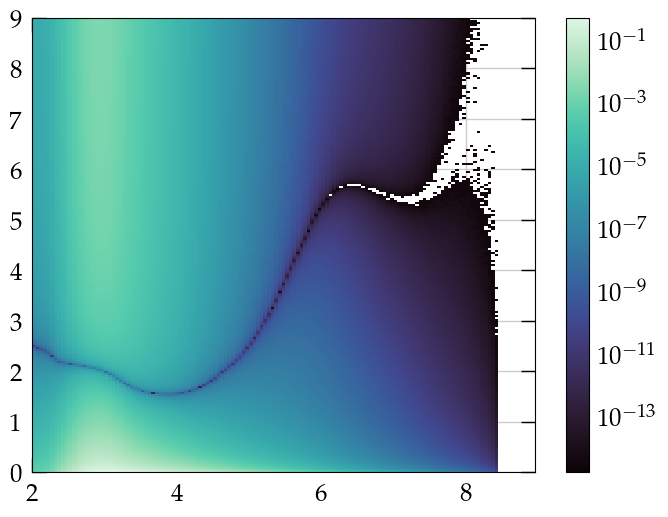

In [24]:
plt.pcolormesh(st.logE_reco_mids, st.psi2_mids, bg_TS - signal_TS, norm=LogNorm())
plt.colorbar()

There are two options:
* Calculate the cumulative TS and find the logE_reco interval boundaries where the cumulative TS hits eg. 0.16 and 0.84.
* Sort the TS values (as a function of logE_reco) and "count down" from the maximum TS until you reach e.g. 68% of the maximum. Translate back to logE_reco and take the min and max edges of the resulting interval

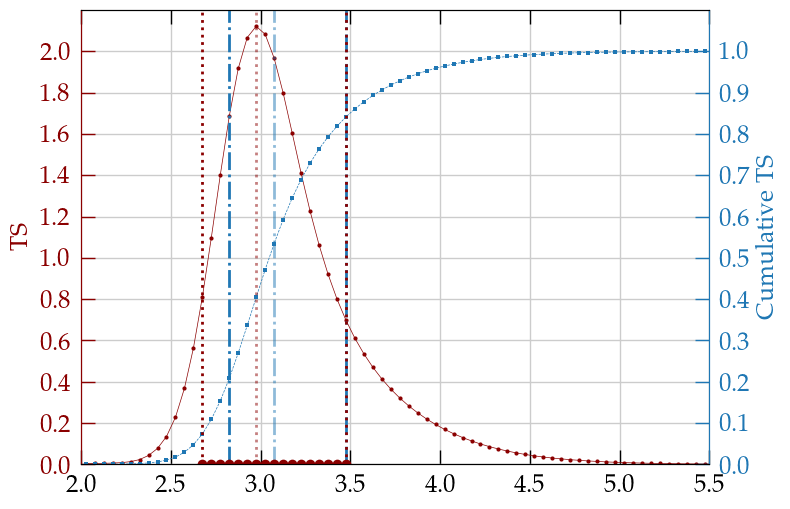

In [ ]:
_TS = bg_TS.sum(axis=0) - signal_TS.sum(axis=0)
normalized_cumulative_TS = np.cumsum(_TS) / np.sum(_TS)
f, ax1 = plt.subplots()
ax2 = plt.twinx()

ax1_color = "darkred"
ax2_color = "tab:blue"

ax2.plot(
    st.logE_reco_mids,
    normalized_cumulative_TS,
    ls="--",
    marker="s",
    lw=0.5,
    ms=3,
    color=ax2_color,
)
ax1.plot(st.logE_reco_mids, _TS, marker="o", lw=0.5, ms=3, color=ax1_color)
ax2.grid(False)

ax1.spines["left"].set_color(ax1_color)
ax2.spines["left"].set_color(ax1_color)
ax2.yaxis.label.set_color(ax2_color)
ax2.tick_params(axis="y", colors=ax2_color)

ax1.spines["right"].set_color(ax2_color)
ax2.spines["right"].set_color(ax2_color)
ax1.yaxis.label.set_color(ax1_color)
ax1.tick_params(axis="y", colors=ax1_color)

ax2.set_ylabel("Cumulative TS")
ax1.set_ylabel("TS")


plt.xlim(2, 5.5)
ax2.set_ylim(0, 1.1)
_ticks = np.arange(0, 1.1, step=0.1)
ax2.set_yticks(_ticks)
ax1.set_ylim(0, 2.2)
_ = ax1.set_yticks(_ticks * 2)

_level = 0.68
# based on cumulative TS
lowE = st.logE_reco_mids[normalized_cumulative_TS >= (1 - _level) / 2][0]
midE = st.logE_reco_mids[normalized_cumulative_TS >= 0.5][0]
upE = st.logE_reco_mids[normalized_cumulative_TS >= 1 - (1 - _level) / 2][0]

plt.axvline(lowE, color=ax2_color, ls="-.")
plt.axvline(midE, color=ax2_color, ls="-.", alpha=0.5)
plt.axvline(upE, color=ax2_color, ls="-.")

# based on max(TS) and "counting down"
_idx_sorted = np.argsort(_TS)[::-1]
_maxidx = _idx_sorted[0]
sorted_TS = _TS[_idx_sorted]
_evalues = st.logE_reco_mids[_idx_sorted][sorted_TS >= np.max(sorted_TS) * (1 - _level)]
# make sure (visually) there are no "holes" in the interval 
# (there shouldnt be, as the TS is monomodal/derivative is monotone)
plt.plot(_evalues, np.zeros_like(_evalues) * 0.1, "o", color=ax1_color) 

plt.axvline(st.logE_reco_mids[_maxidx], color=ax1_color, ls=":", alpha=0.5)
plt.axvline(np.min(_evalues), color=ax1_color, ls=":")
plt.axvline(np.max(_evalues), color=ax1_color, ls=":")